# Data

> #### Extended-representation bisulfite sequencing of gene regulatory elements in multiplexed samples and single cells
https://www.nature.com/articles/s41587-021-00910-x

Data: [GSE149954](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE149954)
- [HL60 Bisulfite-Seq - 10ng dmso](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4518676)
- [HL60 Bisulfite-Seq - 10ng decitabine](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4518677)

### methylKit

- https://github.com/al2na/methylKit
- https://bioconductor.org/packages/release/bioc/html/genomation.html
- https://www.slideshare.net/AlexanderGosdschan/eurobioc-2018-metyhlkit-overview

In [3]:
library(methylKit)
library(DSS)
library(tidyverse)
library(ggrepel)
library(patchwork)
library(genomation)
library(GenomicFeatures)
library(ORFik)
library(ggExtra)

In [4]:
source('../../scripts/util.R')

source('DNAme.R')

In [5]:
sensitivity = c(
"AMBRA1","APCS","API5","ARGLU1","ARHGAP30","ARID4A","ARIH1","ATF7IP","BCL2","BLM","BRMS1","C16orf82","C6orf57",
    "CCAR1","CCDC125","CCDC22","CCDC53","CENPB","CHRM5","CHTOP","CIB4","CMTR2","COL4A5","COMMD1","COMMD2","COMMD4",
    "CP","CSDE1","CSNK1A1","CSNK2A1","CTDSPL2","CTPS1","CXXC4","CYLD","DCP2","DDA1","DDX17","DEF6","DEFB125","DET1",
    "DNAJA2","DYNLRB1","EIF3M","ERCC2","FAF2","FAM58A","FIBP","FZR1","GPATCH8","GPR162","GRB10","HNRNPM","ILF3","INO80E",
    "INTS5","KDM1A","KIAA0195","KIAA0196","LHFPL5","LSM14A","MARK3","MED23","METTL9","MON2","MSN","MTF1","NANS","NOP58",
    "NPRL3","PCBP1","PPP2R1A","PPP6C","PRKRIR","PTEN","PTPN7","PUM1","RAB5C","RABEP1","RALGAPB","RASA2","RASA3","RBBP4",
    "RBM14","RBM14-RBM4","RBM5","REG3G","RFC1","RGS19","RHOA","RNF4","SAMD1","SAP130","SCAF1","SCAF8","SDHAF1","SERF2",
    "SFPQ","SIN3A","SNRPB2","SOCS5","SQLE","SS18","SUPT20H","SYVN1","TAF6L","TBC1D22B","TBRG1","TCERG1","TFRC","TONSL",
    "TOP1","TPTE2","TRIB1","TTC39C","USP22","YTHDC1","ZC3H12D","ZC3H18","ZMYM2"
)

resistance = c(
    "ABHD17A","ACACA","ADAP1","ALG13","ALKBH8","ARL1","ARL2","ATP6V1E2","BCLAF1","BLOC1S3","BRAF","BRD8",
    "C14orf166","C14orf2","C16orf59","CARM1","CBLL1","CCDC134","CCDC6","CCNH","CDK2","CDK7","CENPF","CERS2",
    "CHORDC1","CPD","CSRP2BP","DCK","DCTD","DENR","DHX36","DMAP1","DPF2","EEF1E1","EIF5","ELL","ELP3","ELP5",
    "EP400","EPC1","EPC2","FAM122A","G3BP1","GIT2","GLS","HAUS1","HEATR6","HSD17B12","HSP90B1","HYOU1","IPO13",
    "KIAA1429","KIAA1731","KTI12","LARS2","MAP2K2","MARS","MEAF6","METTL3","MKI67","MRGBP","MRPL34","MRPL41","MRPS17",
    "NCK1","NR2C2AP","PDCL","PET117","PHF20","PITRM1","POLR1D","POLR3B","POLR3F","PPP1R18","PPP1R2","PREX1","PRMT7",
    "PTPLB","RAB3GAP2","RAC2","RANBP3","RAP1GDS1","RHOQ","RNFT1","SHOC2","SLC25A1","SMARCAD1","SNRNP40","SNX15","SRSF11"
    ,"TBCA","TELO2","THAP11","TRPM7","TTI2","VARS2","VPS29","VPS51","VPS54","VWA1","YARS2","YTHDF2","ZC3H13","ZCRB1"

)

## gene/transcript/region level DNA-me scoring

### $$\textrm{DNA-me score} = \frac{\textrm{region CpG count}}{\textrm{region size (bp)}}$$

<!-- \textrm{number of CG}} -->
<!--  + 0.05 -->

In [6]:
normalizeByWidth <- function(me){
    
    width=me$end-me$start
    me$coverage=(me$coverage)/width
    me$numCs=(me$numCs)/width
    me$numTs=(me$numTs)/width
    
    return(me)
}

prepRegion <- function(me){
    # Perform custom normalizeByWidth
    me[[1]] = me[[1]] %>% normalizeByWidth
    me[[2]] = me[[2]] %>% normalizeByWidth
    
    # Merge the samples again
    return(methylKit::unite(me, destrand=FALSE))
}

### Load DNA-me data


In [8]:
CpG_meth <- readRDS(file = "methylKit/CpG_meth.rds")

### Prepare genome annotations 


In [9]:
# First load the annotation data; i.e the coordinates of promoters, TSS, intron and exons
gene.obj = readTranscriptFeatures("../../annotations/genes.bed.gz")

Reading the table...

Calculating intron coordinates...

Calculating exon coordinates...

Calculating TSS coordinates...

Calculating promoter coordinates...

Outputting the final GRangesList...




In [10]:
# Load the CpG info
cpg_anot <- readFeatureFlank("../../annotations/CpG_islands.bed.gz", 
                             feature.flank.name = c("CpGi", "shores"), 
                             flank=2000
                            )

___

In [11]:
GTF = '~/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf'
gtf <- rtracklayer::import(GTF)

In [12]:
gtf$type %>% levels

[1] "gene"           "transcript"     "exon"           "CDS"           
[5] "start_codon"    "stop_codon"     "UTR"            "Selenocysteine"

In [13]:
gene2name <- gtf[gtf$type == "gene"] %>% data.frame %>% 
    column_to_rownames('gene_id') %>% 
    dplyr::select('gene_name')

In [14]:
tx2name <- gtf[gtf$type == "transcript"] %>% data.frame %>% 
    column_to_rownames('transcript_id') %>% 
    dplyr::select('gene_name','transcript_name')

___

https://support.bioconductor.org/p/124164/

In [15]:
txdb  = makeTxDbFromGFF(GTF,organism='Homo sapiens')

Import genomic features from the file as a GRanges object ... 
OK

Prepare the 'metadata' data frame ... 
OK

Make the TxDb object ... 
Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”
OK



In [16]:
txdb

TxDb object:
# Db type: TxDb
# Supporting package: GenomicFeatures
# Data source: ~/genomes/hg38/gencode.v34/gencode.v34.annotation.gtf
# Organism: Homo sapiens
# Taxonomy ID: 9606
# miRBase build ID: NA
# Genome: NA
# Nb of transcripts: 228048
# Db created by: GenomicFeatures package from Bioconductor
# Creation time: 2022-10-19 18:25:43 -0700 (Wed, 19 Oct 2022)
# GenomicFeatures version at creation time: 1.46.1
# RSQLite version at creation time: 2.2.8
# DBSCHEMAVERSION: 1.2

In [17]:
# transcriptsBy(txdb, by=c("gene", "exon", "cds"), use.names=FALSE)
# exonsBy(x, by=c("tx", "gene"), use.names=FALSE)
# cdsBy(x, by=c("tx", "gene"), use.names=FALSE)
# intronsByTranscript(x, use.names=FALSE)
# fiveUTRsByTranscript(x, use.names=FALSE)
# threeUTRsByTranscript(x, use.names=FALSE)

___

In [18]:
enh = readFeatureFlank("../../annotations/enhanceratlas_HL-60.bed", 
                       feature.flank.name = c("enhancer", "na"), flank=2000)

### CpG promoters

upstream = 2000, 
downstream = 200

In [89]:
# prmoters of all gene ids 
suppressWarnings(
    CpG_promoters <- regionCounts(CpG_meth, 
                                  genes(txdb, columns="gene_id") %>% 
                                      promoters(upstream = 2500, downstream = 500) %>% 
                                      unique
                                 ) %>% prepCounts
)

uniting...



In [90]:
CpG_promoters_diff <- methylKit::calculateDiffMeth(CpG_promoters,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 0, qvalue.thr = 1)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [96]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_promoters_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_promoters_diff$all,"GRanges"),feature = gene.obj
)

In [103]:
getPromoterDiff(CpG_promoters_diff$all,CpG_promoters_diff$all.anot) %>% 
    write.table('delta_CpG_promoters_all_table.txt', quote = FALSE, row.names = FALSE, sep = '\t')

In [102]:
getPromoterDiff(CpG_promoters_diff$all,CpG_promoters_diff$all.anot) %>% data.frame %>% 
    dplyr::filter(feature.name == "DCK") 

chr,start,end,strand,pvalue,qvalue,meth.diff,dist.to.feature,feature.name,feature.strand
<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
chr4,70990038,70993037,+,3.402586e-05,0.0003574642,-36.54971,-601,DCK,+


___

In [104]:
CpG_promoters_diff <- methylKit::calculateDiffMeth(CpG_promoters,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.05)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [105]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_promoters_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_promoters_diff$all,"GRanges"),feature = gene.obj
)

In [106]:
getPromoterDiff(CpG_promoters_diff$all,CpG_promoters_diff$all.anot) %>% 
    write.table('delta_CpG_promoters_sig_table.txt', quote = FALSE, row.names = FALSE, sep = '\t')

Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”


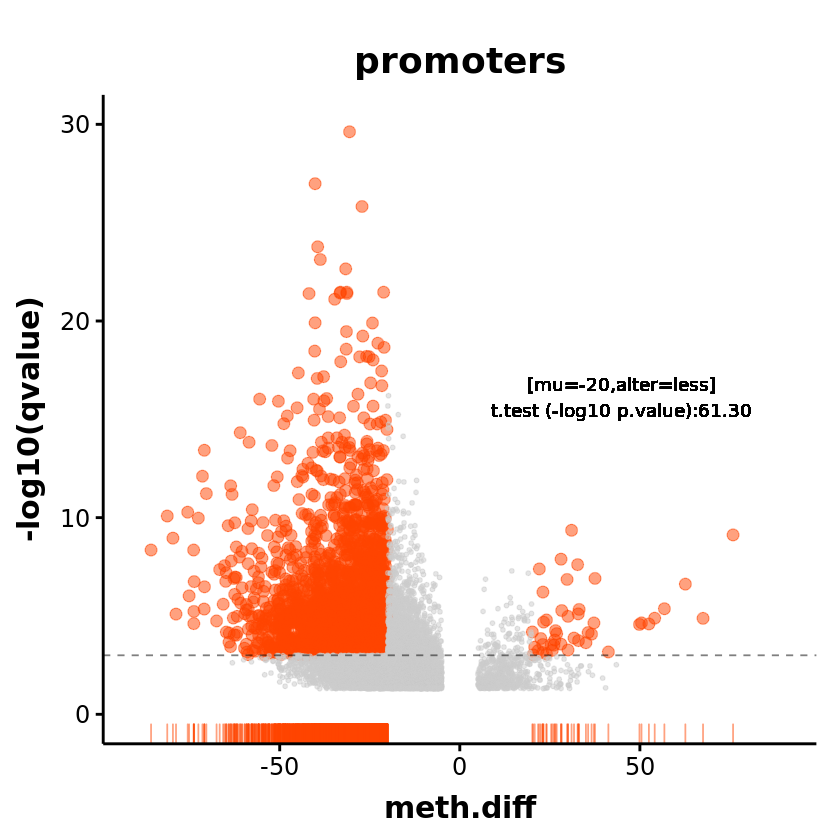

In [111]:
getPromoterDiff(CpG_promoters_diff$all,CpG_promoters_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(20,0.001, hypo_test = T, title = 'promoters', y_lim = 30, x_lim = c(-90,90), mu = -20)

In [112]:
ggsave('plots/diff-DNAme-regions-volcano-promoters.pdf',width=6,height=6)

In [109]:
getPromoterDiff(CpG_promoters_diff$all,CpG_promoters_diff$all.anot) %>% 
    write.table('delta_CpG_promoters_table.txt', quote = FALSE, row.names = FALSE, sep = '\t')

### CpG islands

In [143]:
# prmoters of all gene ids 
suppressWarnings(
    CpG_islands <- regionCounts(CpG_meth, cpg_anot$CpGi %>% unique) %>% prepCounts
    )

uniting...



In [144]:
CpG_islands_diff <- methylKit::calculateDiffMeth(CpG_islands,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [145]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_islands_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_islands_diff$all,"GRanges"),feature = gene.obj
)

Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”


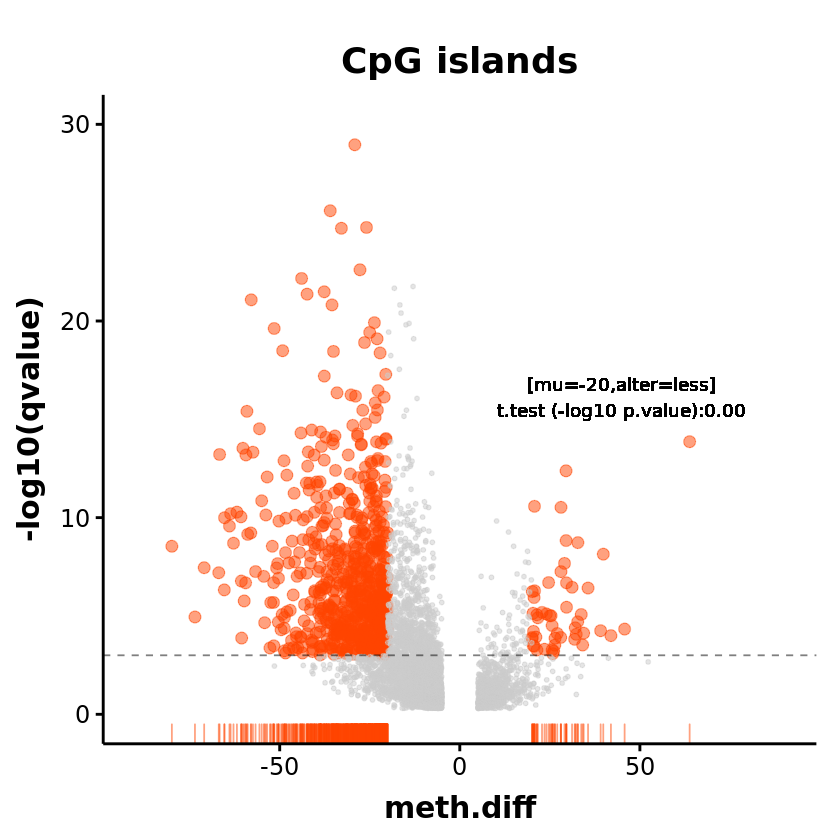

In [207]:
getPromoterDiff(CpG_islands_diff$all,CpG_islands_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(20,0.001, hypo_test = T, title = 'CpG islands', y_lim = 30, x_lim = c(-90,90), mu = -20)

In [208]:
ggsave('plots/diff-DNAme-regions-volcano-CpG_islands.pdf',width=6,height=6)

In [210]:
# # Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# # information ("feature"). This function operates on GRanges objects, so we 
# # first coerce the methylKit object to GRanges.
# CpG_islands_diff$all.anot <- annotateWithGeneParts(
#     target = as(CpG_islands_diff$all,"GRanges"),feature = gene.obj)

In [209]:
# CpG_islands_diff$all %>% dim

# # This can also be summarized for all differentially methylated CpGs
# plotTargetAnnotation(CpG_islands_diff$all.anot, main = "CpG islands\nDifferential Methylation")

### CpG genes

In [164]:
# prmoters of all gene ids 
suppressWarnings(
    CpG_genes <- regionCounts(CpG_meth, genes(txdb, columns="gene_id") %>% unique) %>% prepCounts
    # prepRegion
    )

uniting...



In [168]:
CpG_genes_diff <- methylKit::calculateDiffMeth(CpG_genes,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.2)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [169]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_genes_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_genes_diff$all,"GRanges"),feature = gene.obj
)

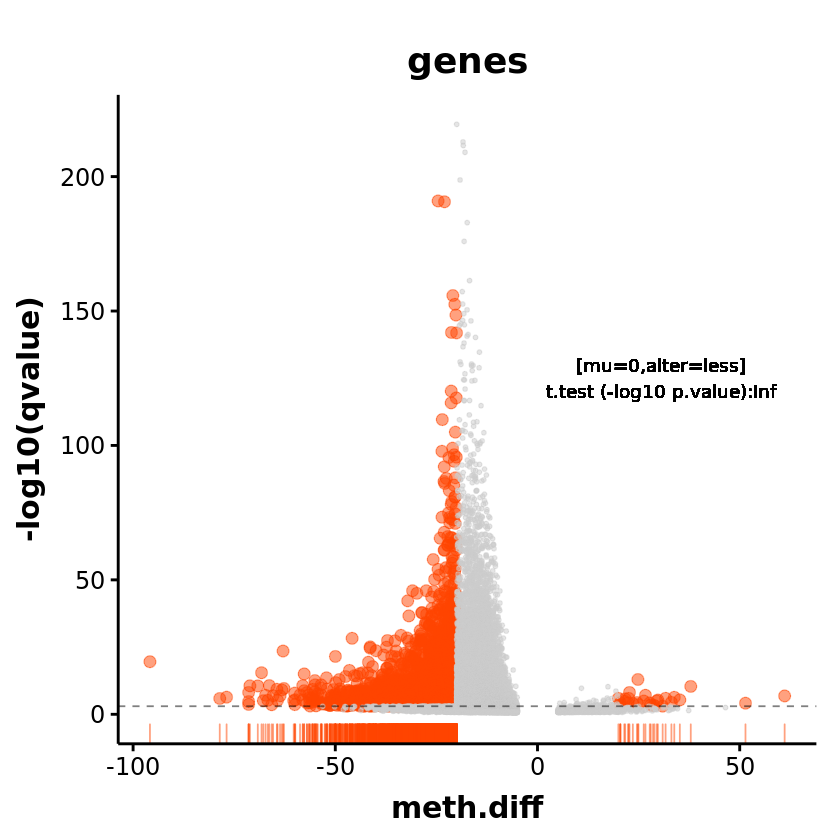

In [170]:
getPromoterDiff(CpG_genes_diff$all,CpG_genes_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(20,0.001, hypo_test = T, title = 'genes')

### CpG CDS

In [35]:
CDS = transcriptsBy(txdb, by=c("cds"), use.names=FALSE) %>% unlist %>% unique
names(CDS) = NULL

In [36]:
suppressWarnings(
    CpG_cds <- regionCounts(CpG_meth, CDS) %>% methylKit::unite(destrand=FALSE) 
    #%>% prepRegion
)

uniting...



In [37]:
CpG_cds_diff <- methylKit::calculateDiffMeth(CpG_cds,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [38]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_cds_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_cds_diff$all,"GRanges"),feature = gene.obj
)

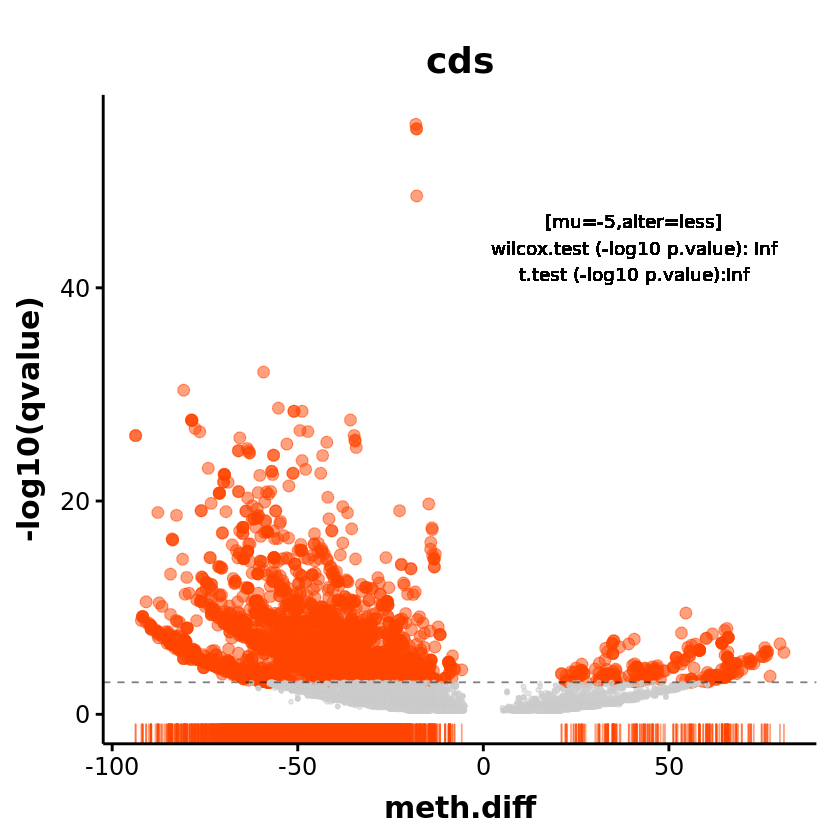

In [39]:
getPromoterDiff(CpG_cds_diff$all,CpG_cds_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(5,0.001, hypo_test = T, title = 'cds')

In [40]:
# getPromoterDiff(CpG_genes_diff$all,CpG_genes_diff$all.anot) %>% data.frame

### CpG exons

In [41]:
suppressWarnings(
    CpG_exons <- regionCounts(CpG_meth, exons(txdb) %>% unique) %>% prepCounts
    #%>% prepRegion
)

uniting...



In [42]:
CpG_exons_diff <- methylKit::calculateDiffMeth(CpG_exons,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [43]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_exons_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_exons_diff$all,"GRanges"),feature = gene.obj
)

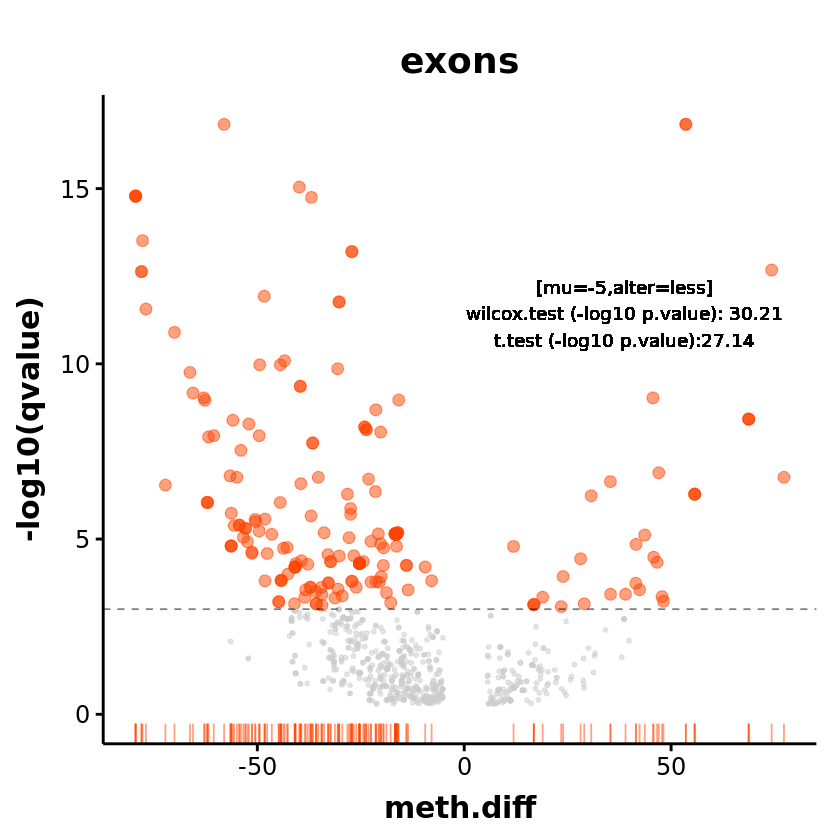

In [44]:
getPromoterDiff(CpG_exons_diff$all,CpG_exons_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(5,0.001, hypo_test = T, title = 'exons')

In [45]:
# getPromoterDiff(CpG_genes_diff$all,CpG_genes_diff$all.anot) %>% data.frame

### CpG introns

In [46]:
introns = intronsByTranscript(txdb) %>% unlist %>% unique
names(introns) = NULL

In [47]:
suppressWarnings(
    CpG_introns <- regionCounts(CpG_meth, introns) %>% prepCounts
    #%>% prepRegion
)

uniting...



In [48]:
CpG_introns_diff <- methylKit::calculateDiffMeth(CpG_introns,overdispersion = "MN",adjust="BH") %>% 
    getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [49]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_introns_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_introns_diff$all,"GRanges"),feature = gene.obj
)

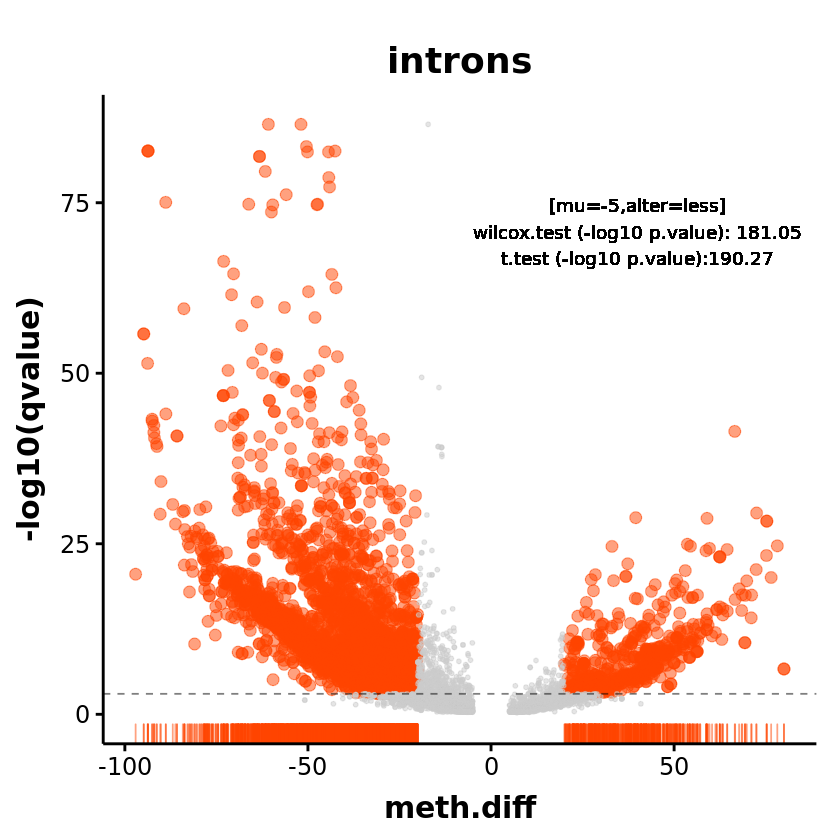

In [50]:
getPromoterDiff(CpG_introns_diff$all,CpG_introns_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(20,0.001, hypo_test = T, title = 'introns')

In [51]:
# getPromoterDiff(CpG_introns_diff$all,CpG_introns_diff$all.anot) %>% data.frame 
# %>% filter(feature.name %in% c(""))

### CpG fiveUTRs

In [67]:
fiveUTRs = fiveUTRsByTranscript(txdb) %>% unlist %>% unique
names(fiveUTRs) = NULL

In [68]:
suppressWarnings(
    CpG_fiveUTRs <- regionCounts(CpG_meth, fiveUTRs) %>% prepCounts
    #%>% prepRegion
)

uniting...



In [69]:
CpG_fiveUTRs_diff = methylKit::calculateDiffMeth(
    CpG_fiveUTRs,
    overdispersion = "MN",adjust="BH"
) %>% getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [70]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_fiveUTRs_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_fiveUTRs_diff$all,"GRanges"),feature = gene.obj
)

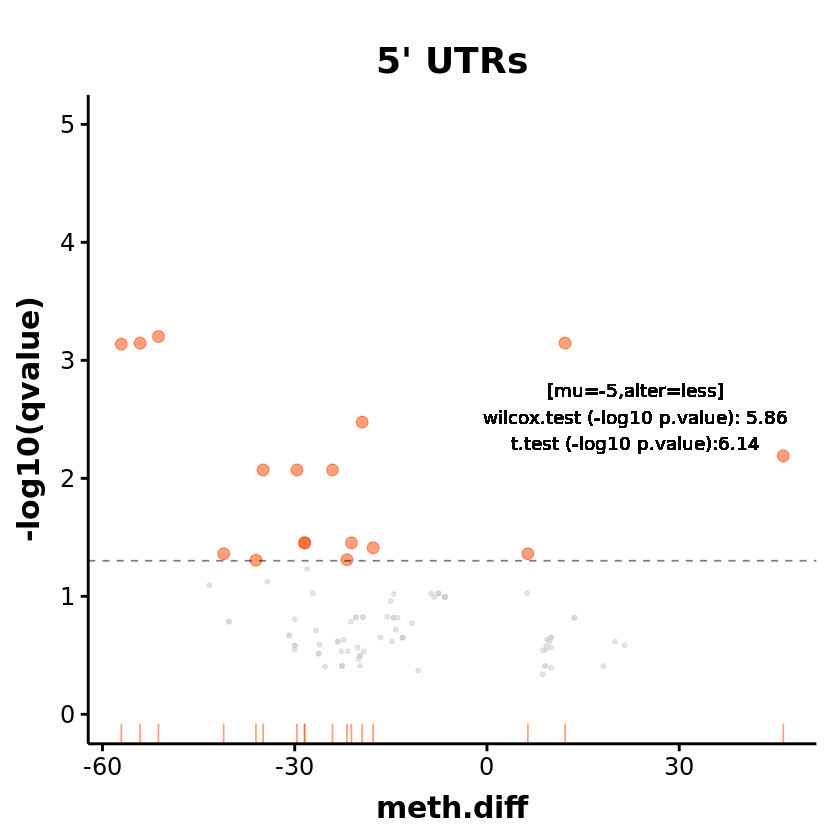

In [71]:
getPromoterDiff(CpG_fiveUTRs_diff$all,CpG_fiveUTRs_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(5,0.05, hypo_test = T, title = "5' UTRs",y_lim = 5)

### CpG threeUTRs

In [72]:
threeUTRs = threeUTRsByTranscript(txdb) %>% unlist %>% unique
names(threeUTRs) = NULL

In [73]:
suppressWarnings(
    CpG_threeUTRs <- regionCounts(CpG_meth, threeUTRs) %>% prepCounts
    # %>% prepRegion
)

uniting...



In [74]:
CpG_threeUTRs_diff = methylKit::calculateDiffMeth(
    CpG_threeUTRs,
    overdispersion = "MN",adjust="BH"
) %>% getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [75]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_threeUTRs_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_threeUTRs_diff$all,"GRanges"),feature = gene.obj
)

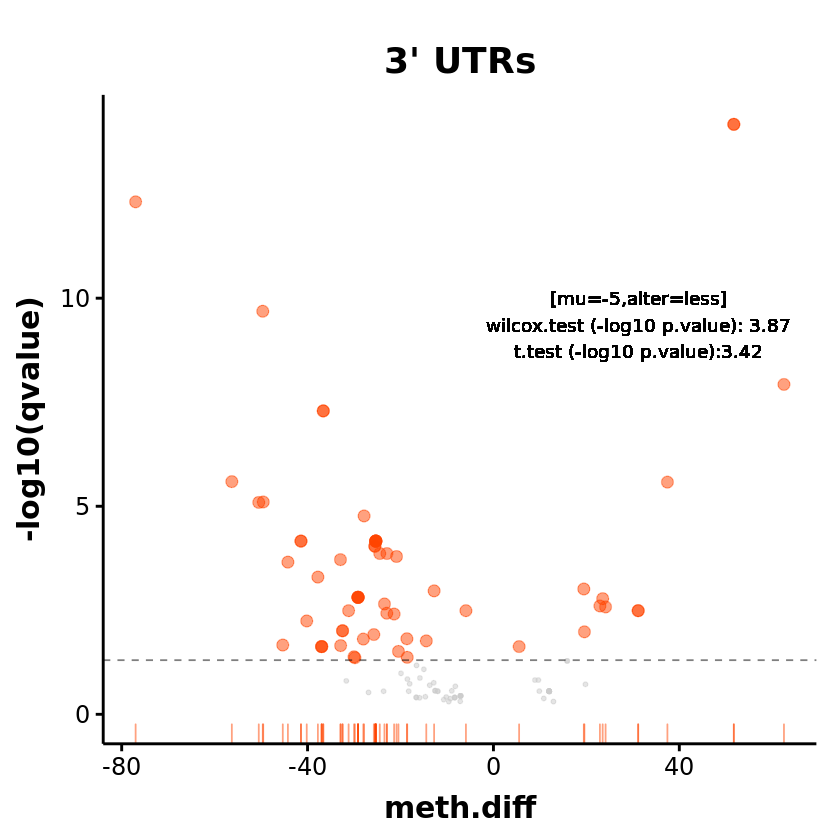

In [78]:
getPromoterDiff(CpG_threeUTRs_diff$all,CpG_threeUTRs_diff$all.anot) %>% data.frame %>% 
    plot_hyperhypo(5,0.05, hypo_test = T, title = "3' UTRs")

### CpG enhancers

In [171]:
suppressWarnings(
    CpG_enhancer <- regionCounts(CpG_meth, enh$enhancer) %>% prepCounts
    # %>% prepRegion
)

uniting...



In [172]:
CpG_enhancer_diff = methylKit::calculateDiffMeth(
    CpG_enhancer,
    overdispersion = "MN",adjust="BH"
) %>% getDiffList(difference.thr = 5, qvalue.thr = 0.5)

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)


 NOTE: performing 'fast.fisher' instead of 'F' for two groups testing.



In [173]:
# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
CpG_enhancer_diff$all.anot <- annotateWithGeneParts(
    target = as(CpG_enhancer_diff$all,"GRanges"),feature = gene.obj
)

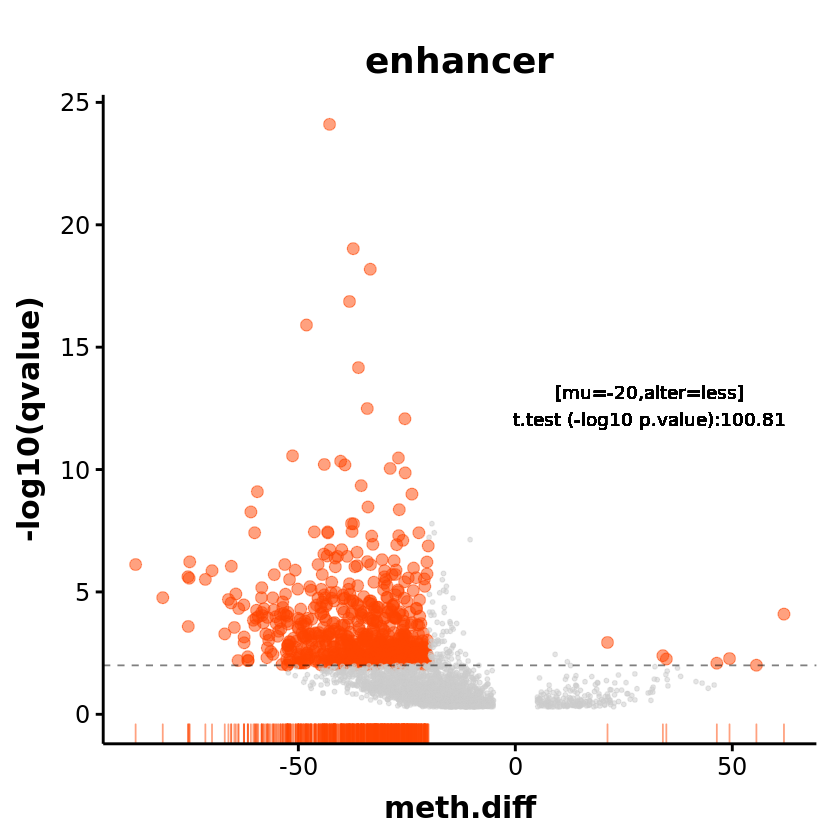

In [178]:
getPromoterDiff(CpG_enhancer_diff$all,CpG_enhancer_diff$all.anot, tss.window = 10**6) %>% data.frame %>% 
    plot_hyperhypo(20,0.01, hypo_test = T, title = "enhancer", mu = -20)

In [189]:
getPromoterDiff(CpG_enhancer_diff$all,CpG_enhancer_diff$all.anot) %>% data.frame %>% 
    filter(abs(meth.diff) > 10 & qvalue < 0.01 & feature.name %in% sensitivity)

chr,start,end,strand,pvalue,qvalue,meth.diff,dist.to.feature,feature.name,feature.strand
<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>


___

## Volcano plots!

In [100]:
# p1 <- CpG_islands_diff$all %>% data.frame %>% 
# plot_hyperhypo(5,0.01,title="CpGi",
#                x_lim = c(-90,90),y_lim = 300) + 
#     theme(
#         #axis.text.y = element_blank(),
#         # axis.ticks.y = element_blank(),
#         axis.title.y = element_blank(),
#         axis.text.x = element_blank(),
#         axis.title.x = element_blank()
#     )

# p2 = CpG_exons_diff$all %>% data.frame %>% 
# plot_hyperhypo(5,0.01,title="Exon",x_lim=c(-90,90),y_lim = 300) + 
#     theme(
#         #axis.text.y = element_blank(),
#         # axis.ticks.y = element_blank(),
#         axis.title.y = element_blank(),
#         # axis.text.x = element_blank(),
#         axis.title.x = element_blank()
#     )


# p3 = CpG_introns_diff$all %>% data.frame %>% 
# plot_hyperhypo(5,0.01,title="Introns",x_lim=c(-90,90),y_lim = 300)+ 
#     theme(
#         axis.text.y = element_blank(),
#         # axis.ticks.y = element_blank(),
#         axis.title.y = element_blank(),
#         # axis.text.x = element_blank(),
#         axis.title.x = element_blank()
#     )

# p4 = CpG_cds_diff$all %>% data.frame %>% 
# plot_hyperhypo(5,0.01,title="CDS",x_lim = c(-90,90),y_lim=18)+ 
#     theme(
#         axis.text.y = element_blank(),
#         # axis.ticks.y = element_blank(),
#         axis.title.y = element_blank(),
#         axis.text.x = element_blank(),
#         axis.title.x = element_blank()
#     )

# p = (p1+p4)/(p2+p3)

Warning message in if (x_lim == FALSE) {:
“the condition has length > 1 and only the first element will be used”


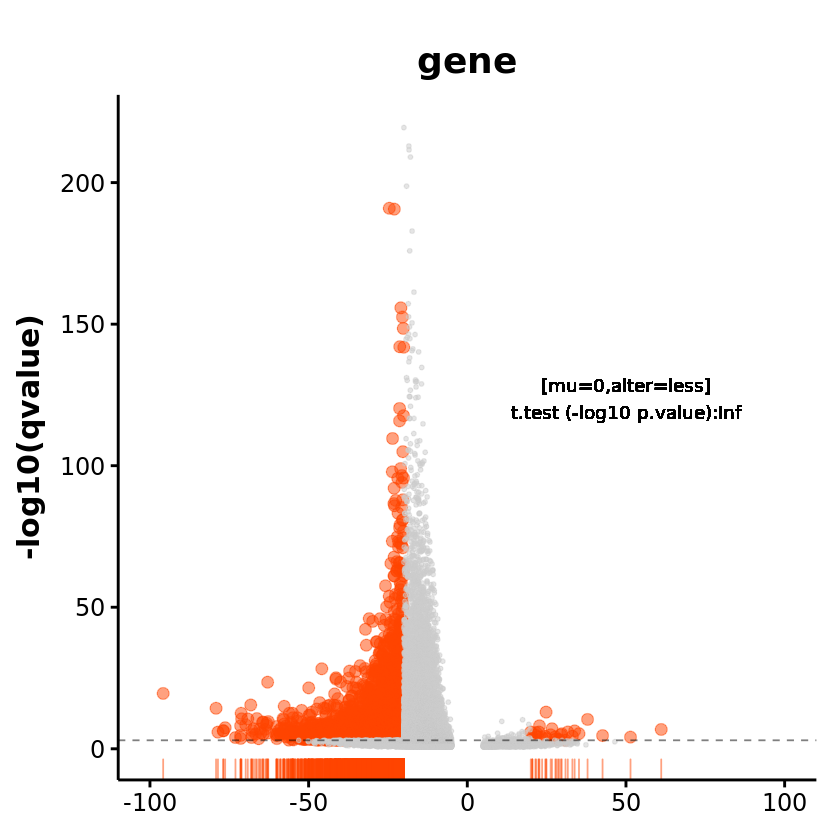

In [195]:
CpG_genes_diff$all %>% data.frame %>% 
plot_hyperhypo(20,0.001,title="gene",x_lim = c(-100,100),y_lim = 220,hypo_test = T) + 
    theme(
        # axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        axis.title.x = element_blank() 
    )#+ 

# CpG_promoters_diff$all %>% data.frame %>% 
#     plot_hyperhypo(5,0.01,title="Promoter",x_lim=c(-90,90),y_lim = 300) + 
#     theme(
#         axis.text.y = element_blank(),
#         # axis.ticks.y = element_blank(),
#         axis.title.y = element_blank() 
#     )+ 

# p

___

In [191]:
# tss.window = 10**6

# getPromoterDiff(
#     CpG_promoters_diff$all, 
#     CpG_promoters_diff$all.anot, 
#     tss.window
# ) %>% plot_hyperhypo(5,0.01,title="",x_lim=c(-99,99),y_lim = 300) + 
# getPromoterDiff(
#     CpG_promoters_diff$all, 
#     CpG_promoters_diff$all.anot, 
#     tss.window
# ) %>% filter(feature.name %in% sensitivity) %>%
# plot_hyperhypo(5,0.05,title="sensitivity",x_lim=c(-90,90),y_lim = 300) + 
#     theme(
#         axis.text.y = element_blank(),
#         # axis.ticks.y = element_blank(),
#         axis.title.y = element_blank() 
#     ) + 

# getPromoterDiff(
#     CpG_promoters_diff$all, 
#     CpG_promoters_diff$all.anot, 
#     tss.window
# ) %>% filter(feature.name %in% resistance) %>%
# plot_hyperhypo(5,0.05,title="resistance",x_lim=c(-90,90),y_lim = 300) + 
#     theme(
#         axis.text.y = element_blank(),
#         # axis.ticks.y = element_blank(),
#         axis.title.y = element_blank() 
#     ) 

# 

In [192]:
sessionInfo()

R version 4.1.2 (2021-11-01)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /data_gilbert/home/aarab/anaconda3/envs/DNAme-DSS/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggthemes_4.2.4              ggExtra_0.10.0             
 [3] ORFik_1.14.7                GenomicAlignments_1.30.0   
 [5] Rsamtools_2.10.0            Biostrings_2.62.0          
 [7] XVector_0.34.0              GenomicFeatures_1.46.1     
 [9] AnnotationDbi_

In [193]:
date()

[1] "Wed Oct 19 16:17:55 2022"